In [12]:
from diffusers import EulerAncestralDiscreteScheduler, AutoencoderKL
import torch
from PIL import Image
import torchvision.transforms as tvtrans
import numpy as np


In [18]:
model_id = 'stabilityai/stable-diffusion-xl-base-1.0'
sub = 1
ndx = 1

In [72]:
vae=AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
# vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", revision=None)

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [45]:
def regularize_image(x):
    """
    upscale images to 512 x 512 and convert to tensor of shape (c x h x w) in range [0, 1]
    """
    BICUBIC = Image.Resampling.BICUBIC
    if isinstance(x, str):
        x = Image.open(x).resize([512, 512], resample=BICUBIC)
        x = tvtrans.ToTensor()(x)
    elif isinstance(x, Image.Image):
        x = x.resize([512, 512], resample=BICUBIC)
        x = tvtrans.ToTensor()(x)
    elif isinstance(x, np.ndarray):
        x = Image.fromarray(x).resize([512, 512], resample=BICUBIC)
        x = tvtrans.ToTensor()(x)
    elif isinstance(x, torch.Tensor):
        pass
    else:
        assert False, 'Unknown image type'

    assert (x.shape[1]==512) & (x.shape[2]==512), \
        'Wrong image size'
    return x


# def encode_img_latents(imgs):
#     if not isinstance(imgs, list):
#         imgs = [imgs]

#     img_arr = np.stack([np.array(img) for img in imgs], axis=0)
#     img_arr = img_arr / 255.0
#     img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2)
#     img_arr = 2 * (img_arr - 0.5)

#     img_arr

#     latent_dists = vae.encode(img_arr.to(device))
#     latent_samples = latent_dists.sample()
#     latent_samples *= 0.18215

#     return latent_dists, latent_samples

# def decode_img_latents(latents):
#     latents = 1 / 0.18215 * latents

#     with torch.no_grad():
#         imgs = vae.decode(latents)

#         imgs = (imgs / 2 + 0.5).clamp(0, 1)
#         imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
#         imgs = (imgs * 255).round().astype('uint8')
#         pil_images = [Image.fromarray(image) for image in imgs]
#         return pil_images


## Initial Image

In [74]:
vae.cuda(0)
# vae.half()
# zim = Image.open('../results/vdvae/subj01/stim/{}.png'.format(ndx))
# zim = regularize_image(zim)
# print(zim.shape)
# # scale linearly to [-1, 1] to ensure that the neural network reverse process 
# # operates on consistently scaled inputs starting from the standard normal prior
# zin = zim*2 - 1

# print(zin.shape)
# zin = zin.unsqueeze(0).cuda(0).half()
# print(zin.shape)

# init_latents = vae.encode(zin).latent_dist.sample()
# print(init_latents.shape, init_latents.dtype)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, ep

In [20]:
gt_stim = np.load('../data/processed_data/subj{:02d}/nsd_test_stim_sub{}.npy'.format(sub,sub)).astype(np.uint8)

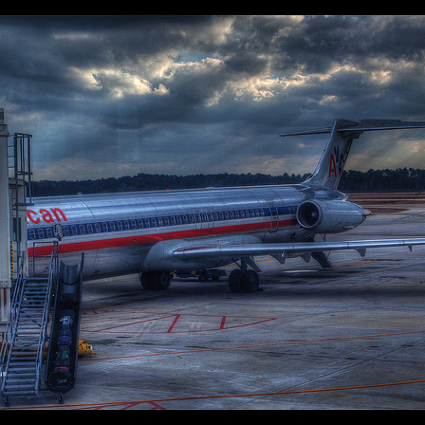

In [21]:
Image.fromarray(gt_stim[ndx])

### Euler Scheduler

In [216]:
# load euler_a scheduler
scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
num_timesteps = 50 
strength=0.75
scheduler.set_timesteps(int(strength * num_timesteps))
print(scheduler)
print(scheduler.timesteps.shape, scheduler.timesteps.dtype)

EulerAncestralDiscreteScheduler {
  "_class_name": "EulerAncestralDiscreteScheduler",
  "_diffusers_version": "0.22.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "interpolation_type": "linear",
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "use_karras_sigmas": false
}

torch.Size([37]) torch.float32


In [217]:
noise = torch.randn_like(init_latents)
noised_latents = scheduler.add_noise(init_latents, noise, scheduler.timesteps)
noised_latents.shape

torch.Size([37, 4, 64, 64])

In [218]:
noised_latents = noised_latents[-1].unsqueeze(0)
noised_latents.shape

torch.Size([1, 4, 64, 64])

### DDPMS Scheduler

In [64]:
from diffusers import DDPMScheduler
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")


In [65]:
num_timesteps = 50 
strength=0.75
scheduler.set_timesteps(int(strength * num_timesteps))
print(scheduler)
print(scheduler.timesteps.shape, scheduler.timesteps.dtype)

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.22.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "interpolation_type": "linear",
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "use_karras_sigmas": false,
  "variance_type": "fixed_small"
}

torch.Size([37]) torch.int64


In [24]:
noise = torch.randn_like(init_latents)
noised_latents = scheduler.add_noise(init_latents, noise, scheduler.timesteps)
noised_latents.shape

torch.Size([37, 4, 64, 64])

In [ ]:
# noised_latents = scheduler.stochas

In [25]:
noised_latents = noised_latents[-1].unsqueeze(0)
noised_latents.shape

torch.Size([1, 4, 64, 64])

## Text Embeddings (test)

In [92]:
noisy_latents = torch.randn((1, 4, 1024//8, 1024//8)).to("cuda")
print(noisy_latents.shape)
input = torch.cat([noisy_latents]*2)
print(input.shape)

torch.Size([1, 4, 128, 128])
torch.Size([2, 4, 128, 128])


In [26]:
sub = 1
test_caps = np.load('../data/processed_data/subj{:02d}/nsd_test_cap_sub{}.npy'.format(sub,sub))

In [27]:
print(test_caps[1])
# print(test_caps[0][0])
# print(len(test_caps[0])) 
annots = test_caps[1]
captions = list(annots[annots!=''])
captions

['' '' 'There is a plane pulled into a port under the clouds.' ''
 'An airplane sits at the airport waiting to be loaded.']


['There is a plane pulled into a port under the clouds.',
 'An airplane sits at the airport waiting to be loaded.']

In [30]:
prompt_embeds_list = []
captions = ['', captions[0], captions[1], "test captions"]

with torch.no_grad():
    for tokenizer, text_encoder in zip(tokenizers, text_encoders):
        text_inputs = tokenizer(
            captions,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        prompt_embeds = text_encoder(
            text_input_ids.to(text_encoder.device),
            output_hidden_states=True,
        )

        # We are only ALWAYS interested in the pooled output of the final text encoder
        pooled_prompt_embeds = prompt_embeds[0]
        print(pooled_prompt_embeds.shape)

        prompt_embeds = prompt_embeds.hidden_states[-2]
        print(prompt_embeds.shape)

        bs_embed, seq_len, _ = prompt_embeds.shape
        prompt_embeds = prompt_embeds.view(bs_embed, seq_len, -1)
        print(prompt_embeds.shape)
        
        prompt_embeds_list.append(prompt_embeds)

        print("-----------------")

prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)
pooled_prompt_embeds = pooled_prompt_embeds.view(bs_embed, -1)

print(len(prompt_embeds_list))
print(prompt_embeds.shape)
print(pooled_prompt_embeds.shape)



torch.Size([4, 77, 768])
torch.Size([4, 77, 768])
torch.Size([4, 77, 768])
-----------------
torch.Size([4, 1280])
torch.Size([4, 77, 1280])
torch.Size([4, 77, 1280])
-----------------
2
torch.Size([4, 77, 2048])
torch.Size([4, 1280])


In [4]:
sub = 1
train_clip = np.load('../data/extracted_features/subj{:02d}/nsd_cliptext_train.npy'.format(sub))

In [11]:
print(train_clip.shape)
print(train_clip[:,0].shape)

(8859, 77, 768)
(8859, 768)


In [18]:
train_clip_v2 = np.load('../data/extracted_features/subj{:02d}/nsd_cliptext_train_v2.npy'.format(sub))

In [19]:
train_clip_v2.shape

(8859, 77, 2048)

In [33]:
train_path = '../data/processed_data/subj{:02d}/nsd_train_fmriavg_nsdgeneral_sub{}.npy'.format(sub,sub)
train_fmri = np.load(train_path)
test_path = '../data/processed_data/subj{:02d}/nsd_test_fmriavg_nsdgeneral_sub{}.npy'.format(sub,sub)
test_fmri = np.load(test_path)

In [14]:
train_fmri.shape

(8859, 15724)

In [10]:
sub = 1
pred_text_pth = '../data/predicted_features/subj{:02d}/nsd_cliptext_predtest_nsdgeneral.npy'.format(sub)
pred_text2_pth = '../data/predicted_features/subj{:02d}/nsd_opencliptext_predtest_nsdgeneral.npy'.format(sub)
pred_text = np.load(pred_text_pth)
pred_text2 = np.load(pred_text2_pth)
test_clip = np.load('../data/extracted_features/subj{:02d}/nsd_cliptext_test.npy'.format(sub))

In [11]:
print(pred_text.shape)
print(pred_text2.shape)
pred_clip = np.zeros_like(test_clip)
print(pred_clip.shape)
print(pred_clip[:,0].shape)
print(pred_clip[:,0:2].shape)
print(pred_clip[0].shape)


(982, 77, 768)
(982, 1280)
(982, 77, 768)
(982, 768)
(982, 2, 768)
(77, 768)


In [53]:
print(test_clip.shape, pred_text.shape, test_fmri.shape)

(982, 77, 768) (982, 77, 768) (982, 15724)


In [52]:
pred_text[:,0].shape

(982, 768)

In [10]:
opencliptext = np.load('../data/predicted_features/subj{:02d}/nsd_opencliptext_penultimate_predtest_nsdgeneral.npy'.format(sub))

In [11]:
opencliptext.shape

(982, 77, 1280)

## Inference

In [29]:
from transformers import AutoTokenizer, PretrainedConfig


def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, revision: str, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder, revision=revision
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection
    else:
        raise ValueError(f"{model_class} is not supported.")


#  CLIP ViT-L
tokenizer_one = AutoTokenizer.from_pretrained(model_id, subfolder="tokenizer", revision=None, use_fast=False)
text_encoder_cls_one = import_model_class_from_model_name_or_path(model_id, None)
text_encoder_one = text_encoder_cls_one.from_pretrained(model_id, subfolder="text_encoder", revision=None)

# OpenCLIP ViT-bigG
tokenizer_two = AutoTokenizer.from_pretrained(model_id, subfolder="tokenizer_2", revision=None, use_fast=False)
text_encoder_cls_two = import_model_class_from_model_name_or_path(model_id, None, subfolder="text_encoder_2")
text_encoder_two = text_encoder_cls_two.from_pretrained(model_id, subfolder="text_encoder_2", revision=None)

text_encoders = [text_encoder_one, text_encoder_two]
tokenizers = [tokenizer_one, tokenizer_two]

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


In [31]:
import random

def encode_prompt(prompt_batch, proportion_empty_prompts, is_train=True):
    prompt_embeds_list = []

    captions = []
    for caption in prompt_batch:
        if random.random() < proportion_empty_prompts:
            captions.append("")
        elif isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])

    with torch.no_grad():
        for tokenizer, text_encoder in zip(tokenizers, text_encoders):
            text_inputs = tokenizer(
                captions,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            prompt_embeds = text_encoder(
                text_input_ids.to(text_encoder.device),
                output_hidden_states=True,
            )

            # We are only ALWAYS interested in the pooled output of the final text encoder
            pooled_prompt_embeds = prompt_embeds[0]
            prompt_embeds = prompt_embeds.hidden_states[-2]
            bs_embed, seq_len, _ = prompt_embeds.shape
            prompt_embeds = prompt_embeds.view(bs_embed, seq_len, -1)
            prompt_embeds_list.append(prompt_embeds)

    prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)
    pooled_prompt_embeds = pooled_prompt_embeds.view(bs_embed, -1)
    return prompt_embeds, pooled_prompt_embeds


def compute_embeddings(prompt_batch, proportion_empty_prompts, text_encoders, tokenizers, size, is_train=True):
    original_size = size
    target_size = size
    crops_coords_top_left = (0, 0)

    prompt_embeds, pooled_prompt_embeds = encode_prompt(
        prompt_batch, proportion_empty_prompts, is_train
    )
    add_text_embeds = pooled_prompt_embeds

    # Adapted from pipeline.StableDiffusionXLPipeline._get_add_time_ids
    add_time_ids = list(original_size + crops_coords_top_left + target_size)
    add_time_ids = torch.tensor([add_time_ids])

    prompt_embeds = prompt_embeds.to(device)
    add_text_embeds = add_text_embeds.to(device)
    add_time_ids = add_time_ids.repeat(len(prompt_batch), 1)
    add_time_ids = add_time_ids.to(device, dtype=prompt_embeds.dtype)
    unet_added_cond_kwargs = {"text_embeds": add_text_embeds.half(), "time_ids": add_time_ids.half()}

    return {"prompt_embeds": prompt_embeds.half()}, unet_added_cond_kwargs


def compute_embeddings_v2(prompt_batch, prompt_embeds, pooled_prompt_embeds, size, proportion_empty_prompts, is_train=True):
    original_size = size
    target_size = size
    crops_coords_top_left = (0, 0)

    prompt_n_embeds, pooled_prompt_n_embeds = encode_prompt(
        prompt_batch, proportion_empty_prompts, is_train
    )

    prompt_embeds = torch.cat((prompt_n_embeds, prompt_embeds), dim=0)
    pooled_prompt_embeds = torch.cat((pooled_prompt_n_embeds, pooled_prompt_embeds), dim=0)

    add_text_embeds = pooled_prompt_embeds 

    # return prompt_embeds, pooled_prompt_embeds

    # Adapted from pipeline.StableDiffusionXLPipeline._get_add_time_ids
    add_time_ids = list(original_size + crops_coords_top_left + target_size)
    add_time_ids = torch.tensor([add_time_ids])

    prompt_embeds = prompt_embeds.to(device)
    add_text_embeds = add_text_embeds.to(device)
    add_time_ids = add_time_ids.repeat(len(prompt_batch)+1, 1)
    add_time_ids = add_time_ids.to(device, dtype=prompt_embeds.dtype)
    unet_added_cond_kwargs = {"text_embeds": add_text_embeds.half(), "time_ids": add_time_ids.half()}

    return {"prompt_embeds": prompt_embeds.half()}, unet_added_cond_kwargs


def compute_embeddings_v3(prompt_batch, prompt_embeds, pooled_prompt_embeds, size, proportion_empty_prompts, is_train=True):
    original_size = size
    target_size = size
    crops_coords_top_left = (0, 0)

    prompt_n_embeds, pooled_prompt_n_embeds = encode_prompt(
        prompt_batch, proportion_empty_prompts, is_train
    )

    prompt_embeds = torch.cat((prompt_n_embeds, prompt_embeds), dim=0)
    pooled_prompt_embeds = torch.cat((pooled_prompt_n_embeds, pooled_prompt_embeds), dim=0)

    add_text_embeds = pooled_prompt_embeds 

    # return prompt_embeds, pooled_prompt_embeds

    # Adapted from pipeline.StableDiffusionXLPipeline._get_add_time_ids
    add_time_ids = list(original_size + crops_coords_top_left + target_size)
    add_time_ids = torch.tensor([add_time_ids])

    prompt_embeds = prompt_embeds.to(device)
    add_text_embeds = add_text_embeds.to(device)
    add_time_ids = add_time_ids.repeat(len(prompt_batch)+1, 1)
    add_time_ids = add_time_ids.to(device, dtype=prompt_embeds.dtype)
    unet_added_cond_kwargs = {"text_embeds": add_text_embeds.half(), "time_ids": add_time_ids.half()}

    return {"prompt_embeds": prompt_embeds.half()}, unet_added_cond_kwargs


In [101]:
sub=1
prompt_n = "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured, worst quality, low quality"
prompt_batch = [prompt_n]

# normalized clip embs
# pred_cliptext = np.load('../data/predicted_features/subj{:02d}/nsd_cliptext_predtest_nsdgeneral_v2.npy'.format(sub))
# pred_opencliptext = np.load('../data/predicted_features/subj{:02d}/nsd_opencliptext_predtest_nsdgeneral.npy'.format(sub))

# not normalized clip embs
pred_cliptext = np.load('../data/predicted_features/subj{:02d}/nsd_cliptext_predtest_nsdgeneral_v3.npy'.format(sub))
pred_opencliptext = np.load('../data/predicted_features/subj{:02d}/nsd_opencliptext_predtest_nsdgeneral_v2.npy'.format(sub))

pred_cliptext = torch.from_numpy(pred_cliptext)
pred_opencliptext = torch.from_numpy(pred_opencliptext)

print(pred_cliptext.shape, pred_opencliptext.shape)
print(pred_cliptext[ndx].unsqueeze(0).shape, pred_opencliptext[ndx].unsqueeze(0).shape)

torch.Size([982, 77, 2048]) torch.Size([982, 1280])
torch.Size([1, 77, 2048]) torch.Size([1, 1280])


In [102]:
prompt_embeds, unet_added_cond_kwargs = compute_embeddings_v2(
    prompt_batch=prompt_batch, prompt_embeds=pred_cliptext[ndx].unsqueeze(0), pooled_prompt_embeds=pred_opencliptext[ndx].unsqueeze(0), size=(512, 512), proportion_empty_prompts=0
)

print(prompt_embeds.keys(), prompt_embeds["prompt_embeds"].shape)
print(unet_added_cond_kwargs.keys(), unet_added_cond_kwargs["text_embeds"].shape, unet_added_cond_kwargs["time_ids"].shape)

# print(prompt_embeds.shape)
# print(unet_added_cond_kwargs.shape)

# print(prompt_embeds)
# print(unet_added_cond_kwargs)


dict_keys(['prompt_embeds']) torch.Size([2, 77, 2048])
dict_keys(['text_embeds', 'time_ids']) torch.Size([2, 1280]) torch.Size([2, 6])


In [55]:
# test actual text prompt
prompt_n = "extra digit, fewer digits, cropped, worst quality, low quality"
prompt_batch2 = [prompt_n, "A cat playing with yarn, 4k photo, in real world, realistic, highly detailed, "]

prompt_embeds, unet_added_cond_kwargs = compute_embeddings(
    prompt_batch=prompt_batch2, proportion_empty_prompts=0, text_encoders=text_encoders, tokenizers=tokenizers, size=(512, 512)
)

print(prompt_embeds.keys(), prompt_embeds["prompt_embeds"].shape)
print(unet_added_cond_kwargs.keys(), unet_added_cond_kwargs["text_embeds"].shape, unet_added_cond_kwargs["time_ids"].shape)

dict_keys(['prompt_embeds']) torch.Size([2, 77, 2048])
dict_keys(['text_embeds', 'time_ids']) torch.Size([2, 1280]) torch.Size([2, 6])


In [34]:
import sys, os
sys.path.insert(0, os.path.abspath('../T2I-Adapter'))
# sys.path.append('T2I-Adapter')

from models.unet import UNet
from basicsr.utils import tensor2img
import tqdm
import copy

model = UNet.from_pretrained(model_id, subfolder="unet").half().to(device)

c:\Users\gabri\anaconda3\envs\brain-decoding\Lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [36]:
noisy_latents = noised_latents
scheduler.set_timesteps(37)
print(noisy_latents.shape, scheduler.timesteps.shape)
scheduler

torch.Size([1, 4, 64, 64]) torch.Size([37])


DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.22.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "interpolation_type": "linear",
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "use_karras_sigmas": false,
  "variance_type": "fixed_small"
}

In [111]:
# test pure noise 
noisy_latents = torch.randn((1, 4, 512//8, 512//8)).half().to("cuda")
scheduler.set_timesteps(50)
print(noisy_latents.shape, scheduler.timesteps.shape)
scheduler

torch.Size([1, 4, 64, 64]) torch.Size([50])


DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.22.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "interpolation_type": "linear",
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "use_karras_sigmas": false,
  "variance_type": "fixed_small"
}

In [104]:
print(noisy_latents.dtype)
print(prompt_embeds["prompt_embeds"].dtype)
print(unet_added_cond_kwargs["text_embeds"].dtype)
print(unet_added_cond_kwargs["time_ids"].dtype)
print(torch.cat([noised_latents]*2).dtype)

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16


In [112]:
adapter_features = None
guidance_scale=7.5 

with torch.no_grad():
    for t in tqdm.tqdm(scheduler.timesteps):
        with torch.no_grad():
            input = torch.cat([noisy_latents]*2)
            # input = scheduler.scale_model_input(input, t)
            noise_pred = model(
                    input,
                    t,
                    encoder_hidden_states=prompt_embeds["prompt_embeds"],
                    added_cond_kwargs=unet_added_cond_kwargs,
                    down_block_additional_residuals=copy.deepcopy(adapter_features),
                ).sample
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            # print(noise_pred.shape, noisy_latents.shape)
            noisy_latents = scheduler.step(noise_pred, t, noisy_latents).prev_sample

100%|██████████| 50/50 [02:13<00:00,  2.67s/it]


In [113]:
# vae.to("cpu")
# image = vae.decode(noised_latents.cpu() / vae.config.scaling_factor, return_dict=False)[0]
image = vae.decode(noisy_latents / vae.config.scaling_factor, return_dict=False)[0]
image = (image / 2 + 0.5).clamp(0, 1)
image = tensor2img(image)
image

array([[[ 46,   7,   8],
        [105,  17,   7],
        [202,  53,   3],
        ...,
        [207,  39,   0],
        [162,  28,   2],
        [ 93,  13,   6]],

       [[ 33,  17,  17],
        [ 97,  30,  17],
        [190,  47,   8],
        ...,
        [208,  35,   0],
        [173,  34,   5],
        [ 86,   8,   7]],

       [[ 21,  13,  21],
        [ 83,  33,  26],
        [191,  49,   9],
        ...,
        [206,  33,   0],
        [177,  35,   8],
        [ 67,   8,  17]],

       ...,

       [[  0,   0,  11],
        [ 39,  18,  10],
        [176,  32,   3],
        ...,
        [185,  27,   2],
        [137,  25,  10],
        [ 52,   6,  12]],

       [[  2,   6,  12],
        [ 50,  13,   3],
        [176,  33,   4],
        ...,
        [187,  29,   0],
        [143,  28,   6],
        [ 76,  12,  10]],

       [[ 15,   1,   9],
        [ 62,   5,   4],
        [176,  34,   7],
        ...,
        [178,  31,   5],
        [137,  27,  10],
        [ 78,  14,  14]]

In [146]:
# print(image.shape)
# print(type(image[:,:,::-1]),image[:,:,::-1].shape)
# image[:,:,::-1]

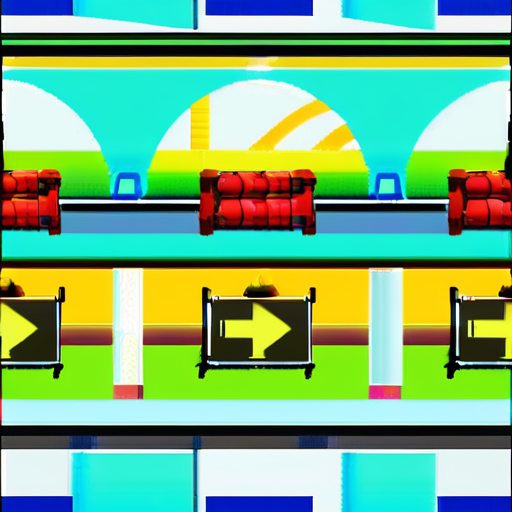

In [114]:
from PIL import Image 

img = Image.fromarray(image[:,:,::-1])
# img = Image.fromarray(image)
img